In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import matplotlib.pyplot as plt
from typing import *

In [2]:
torch.__version__

'1.12.1+cpu'

# Transformer

![](https://i.stack.imgur.com/eAKQu.png)

    (10,32,128) -> (batch_size, seq_len, embedding_size)
    

### Steps

1. Input pass through Embedding layer.
2. inputEmbedding + PositionalEmbedding = resEmbedding.
3. Encoder takes input resEmbedding.
4. EncodedEmbedding and outputShift pass thorugh Decoder.

# Positional Embedding

![](https://machinelearningmastery.com/wp-content/uploads/2022/01/PE1-1024x545.png "Positional Embedding")

## Positional embedding
![](https://miro.medium.com/max/370/1*5qEu5eRUL_a-BE29Pb47zw.png)

‘PE’ is a function of the position of the word in the sequence (‘pos’), and the embedding (i)
 
That gives the value for the word at position ‘pos’ and embedding index ‘i’. ‘pos’ holds constant for the word as the embedding index, ‘i’ increases, giving a unique pattern for that word

In [3]:
def positional_embedding(sequence_length, embedding_size):
    pos = torch.arange(sequence_length,dtype=torch.float).view(-1,1)
    i = torch.arange(embedding_size,dtype=torch.float).view(1,-1)
    angle = 1/(torch.pow(10000, 2*i/embedding_size))
    angle = pos*angle
    angle[:,0::2] = torch.sin(angle[:,0::2])
    angle[:,1::2] = torch.cos(angle[:,1::2])
    return angle

In [4]:
res = positional_embedding(128,100)
res.shape

torch.Size([128, 100])

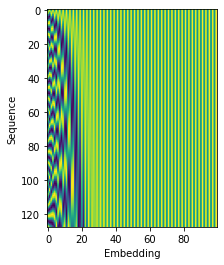

In [5]:
plt.imshow(res)
plt.xlabel("Embedding")
plt.ylabel("Sequence")
plt.show()

## Multi head Attention

<!-- <div> -->
<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" width="500" />
<!-- </div> -->

### First we need Scaled Dot-Product Attention
Attention(Q, K, V ) = softmax( (Q*Kt)/dk ) V

In [6]:
class Attention(nn.Module):
    def __init__(self,seq_len, embedding_size, mask=False):
        super(Attention, self).__init__()
        self.emb_size = embedding_size
        self.mask = mask
        
    def forward(self, Q:torch.Tensor, K:torch.Tensor, V:torch.Tensor):
        '''
        args:
            query, key, value
        '''
        I = Q@torch.transpose(K,-2,-1)
        if self.mask is not None:
             I = I.masked_fill(mask!=0, -torch.inf)
        return F.softmax(I/self.emb_size,dim=1)@V

In [8]:
x = torch.randn(2,6,10,15)
att = Attention(10,15,mask=False)
# att(x,x,x).shape

### Multi head Attention module

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, seq_len, emb_size, h=8, mask=False):
        super().__init__()
        assert emb_size%h == 0, "embedding_size should be multiple h"
        self.seq_len = seq_len
        self.emb_size = emb_size
        self.h = h
        self.dk = emb_size//h
        self.linear_k = nn.Linear(emb_size, emb_size,bias=True)
        self.linear_v = nn.Linear(emb_size, emb_size,bias=True)
        self.linear_q = nn.Linear(emb_size, emb_size,bias=True)
        self.linear_o = nn.Linear(emb_size, emb_size,bias=True)
        self.mask = mask
    
    def split(self,x):
        x_s = x.shape
        return x.view(x_s[0],x_s[1],self.h,self.dk).permute(0,2,1,3)

    def forward(self,x,y,z):
        '''
        x - key, y - value, z - query
        '''
        K = self.linear_k(x)
        V = self.linear_v(y)
        Q = self.linear_q(z)
        k_s = K.shape
        q_s = Q.shape
        
        K = self.split(K)
        V = self.split(V)
        Q = self.split(Q)
        
        I = Q@K.permute(0,1,3,2)
        
        if self.mask:
            mask = torch.triu(torch.ones(self.h,q_s[1],k_s[1]),diagonal=1)
            I = I.masked_fill(mask!=0,-torch.inf)
            
        attention = F.softmax(I/math.pow(self.dk,0.5),dim=-1) ## batch, head, query_len, key_len
        f = attention@V
        f = f.permute(0,2,1,3).reshape(q_s)
        return self.linear_o(f)

In [10]:
x = torch.randn(2,10,128)
q = torch.randn(2,1,128)
mha = MultiHeadAttention(10,128,8,mask=True)
o = mha(x,x,q)

In [11]:
o.shape

torch.Size([2, 1, 128])

### EncodeBlock

In [12]:
class EncodeBlock(nn.Module):
    def __init__(self, seq_len, hidden_dim,head=8):
        super().__init__()
        self.norm = nn.LayerNorm(hidden_dim)
        self.activation = nn.ReLU()
        self.attention = MultiHeadAttention(seq_len,hidden_dim,head)
        self.feed = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self,x):
        x = x + self.attention(x,x,x)
        x = self.norm(self.activation(x))
        
        x = self.feed(x) + x
        x = self.norm(self.activation(x))
        return x

In [13]:
encoder_blk = EncodeBlock(10,128,8)
o = encoder_blk(x)

### Encoder

In [14]:
class Encoder(nn.Module):
    def __init__(self, n_encoder, seq_len, hidden_dim,head=8):
        super().__init__()
        encoders = []
        
        for i in range(n_encoder):
            encoders.append(EncodeBlock(seq_len, hidden_dim,head=8))
        
        self.encoders = nn.Sequential(*encoders)
    
    def forward(self,x):
        return self.encoders(x)

In [15]:
encoder = Encoder(10,10,128,8)
encoder(x).shape

torch.Size([2, 10, 128])

### DecodeBlock

In [16]:
class DecodeBlock(nn.Module):
    def __init__(self, seq_len, hidden_dim,head=8):
        super().__init__()
        
        self.norm = nn.LayerNorm(hidden_dim)
        self.activation = nn.ReLU()
        self.self_attention = MultiHeadAttention(seq_len,hidden_dim,head,mask=True)
        self.encode_decode_attention = MultiHeadAttention(seq_len,hidden_dim,head)
        self.feed = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x):
        encode_info_x, x = x
        x = x + self.self_attention(x,x,x)
        x = self.norm(self.activation(x))
        
        x = x + self.encode_decode_attention(encode_info_x,encode_info_x,x)
        x = self.norm(self.activation(x))
        
        x = self.feed(x) + x
        x = self.norm(self.activation(x))
        return encode_info_x, x

In [17]:
decoder_blk = DecodeBlock(10,128,8)
o = decoder_blk((x, x))
o[0].shape, o[1].shape

(torch.Size([2, 10, 128]), torch.Size([2, 10, 128]))

### Decoder

In [18]:
class Decoder(nn.Module):
    def __init__(self, n_decoder, seq_len, hidden_dim,head=8):
        super().__init__()
        decoders = []
        
        for i in range(n_decoder):
            decoders.append(DecodeBlock(seq_len, hidden_dim,head=8))
        
        self.decoders = nn.Sequential(*decoders)
    
    def forward(self, x):
        his, x = x
        return self.decoders((his, x))

In [19]:
decoder = Decoder(10,10,128,8)
o = decoder((x,x))
o[0].shape, o[1].shape

(torch.Size([2, 10, 128]), torch.Size([2, 10, 128]))

## Transformer

In [20]:
class Transformer(nn.Module):
    def __init__(
        self,
        N,
        hidden_dim,
        head,
        encoder_seq_len,
        decoder_seq_len,
        num_encoder_token,
        num_decoder_token
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.head = head
        self.encoder_seq_len = encoder_seq_len
        self.decoder_seq_len = decoder_seq_len
        
        self.encoder_embedding = nn.Embedding(num_encoder_token, hidden_dim)
        self.decoder_embedding = nn.Embedding(num_decoder_token, hidden_dim)
        
        self.positional_emb_encoder = positional_embedding(encoder_seq_len, hidden_dim)
        self.positional_emb_decoder = positional_embedding(decoder_seq_len, hidden_dim)
        self.encoder = Encoder(N, encoder_seq_len, hidden_dim, head)
        self.decoder = Decoder(N, decoder_seq_len, hidden_dim, head)
        
        self.fc = None
        
    def forward(self, inputs, outputs):
        x_i = self.encoder_embedding(inputs)
        x_o = self.decoder_embedding(outputs)
        
        ### encoder
        x_i = x_i+self.positional_emb_encoder
        x_i = self.encoder(x_i)
        
        ### decoder
        x_o = x_o+self.positional_emb_decoder
        _,x_o = self.decoder((x_i,x_o))
        if self.fc:
            x_o = self.fc(x_o)
        return x_o

In [27]:
N = 10 # size of encoder and decoder blocks
embedding_size = 128
heads = 8
encoder_seq_len = 10
decoder_seq_len = 1
num_encoder_token = 1000
num_decoder_token = 1000

transformer = Transformer(
    N,
    embedding_size,
    heads,
    encoder_seq_len,
    decoder_seq_len,
    num_encoder_token,
    num_decoder_token
)

In [29]:
transformer.fc = nn.Sequential(
    nn.Linear(transformer.hidden_dim,64),
    nn.Softmax(dim=-1)
)

In [30]:
x = torch.randn(2,10)
_x = torch.randn(2,1)

In [24]:
x = x*100
x = x.int()
x = torch.clamp(x, min=0,max=1000)

_x = _x*100
_x = _x.int()
_x = torch.clamp(_x, min=0,max=1000)

In [25]:
o = transformer(x,_x)

In [26]:
o.shape

torch.Size([2, 1, 64])

### Try it!

#### dataloader

#### loss function

#### train_step

#### Train

#### Evaluate